# Monte Carlo Ising Model

In [1]:
import numpy as np
from scipy.ndimage import convolve
from scipy.signal import convolve2d, fftconvolve
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

# Simulation function
Monte Carlo Ising model

In [2]:
def adj_spins(spins: np.ndarray, x: int, y: int, dim: int):
    """Calculate the sum of spins adjacent to a particular coordinate

    Parameters
    ----------
    spins : np.ndarray
        The array of spins
    x : int
        The x coordinate of the point
    y : int
        The y coordinate of the point
    dim : int
        The dimensionality of the system coordinate of the point

    Returns
    -------
    adj: float
        The sum of adjacent spins
    """
    return (spins[(x+1)%dim, (y)%dim]+
       spins[(x-1)%dim, (y)%dim]+
       spins[(x)%dim, (y+1)%dim]+
       spins[(x)%dim, (y-1)%dim])
def ising_mc(L:int =2,
             T:float = 1,
             B:float = 0,
             n_equib:int = 1000,
             n_sim:int = 10000,
             mu:float = 1,
             J:float = 1,
             k:float =1):
    """MC implementation of Ising model: returns array of energies and magnetisms"

    Parameters
    ----------
    L : int, optional
        The dimensions of the grid, by default 2
    T : float, optional
        The temperature, by default 1
    B : float, optional
        The external field, by default 0
    n_equib : int, optional
        The number of equilibration cycles to perform (1 cycle considers n x n flips), by default 1000
    n_sim : int, optional
        The number of simulation cycles to perform (1 cycle considers n x n flips), by default 10000
    mu : float, optional
        The spin magnetic moment, by default 1
    J : float, optional
        The interaction parameter between adjacent spins, by default 1
    k : float, optional
        Boltzmanns constan, by default 1

    Returns
    -------
    E: np.ndarray
        The energy at each simulation cycle step
    M: np.ndarray
        The magnetism at each simulation cycle step
    """
    # reset seed every call for reproducibility
    np.random.seed(0)
    # generate initial random array of spins
    spins = np.where((np.random.rand(L,L)<0.5), -1 , 1)
    # kernel for convolution for nearest neighbours
    kernel = np.array(((0,1,0),
                   (1,0,1),
                   (0,1,0)))
    # equilibrate spin state
    for _ in range(L*L*n_equib):
        # pick random location
        x, y = np.random.randint(0,L,2)
        # calculate adjacency matrix
        # adj = convolve(spins, kernel, mode = 'wrap') # wrap for periodicity
        # get the spin on the site to flip
        spin = spins[x, y]
        adj = adj_spins(spins, x, y, L)
        # get the contribution from interaction with external field
        E_ext = 2*B*spin*mu # old: -B*spin*mu, new B*spin*mu, delta = Enew-Eold
        # get the contribution from interaction with adjacent spins
        E_int = 2*J*spin*adj
        # overall delta
        delta = E_int+E_ext
        if delta<0:
            spins[x, y]=-spin
        elif np.exp(-delta/(k*T))>np.random.rand():
            spins[x, y]=-spin
    # simulation cycling
    E = []
    M = []
    # calculate overall moment and energy
    m = np.sum(spins)
    e = -B*mu*m - J*np.sum(np.multiply(convolve(spins, kernel, mode = 'wrap'), spins))/2
    E.append(e)
    M.append(m)
    for _ in range(L*L*n_sim):
        # pick random location
        x, y = np.random.randint(0,L,2)
        # get the spin on the site to flip
        spin = spins[x, y]
        adj = adj_spins(spins, x, y, L)
        # get the contribution from interaction with external field
        E_ext = 2*B*spin*mu # old: -B*spin*mu, new B*spin*mu, delta = Enew-Eold
        # get the contribution from interaction with adjacent spins
        E_int = 2*J*spin*adj
        # overall delta
        delta = E_int+E_ext
        if delta<0:
            spins[x, y]=-spin
            e = e + delta
            m = m-2*spin
            E.append(e)
            M.append(m)
        elif np.exp(-delta/(k*T))>np.random.rand():
            spins[x, y]=-spin
            e = e + delta
            m = m-2*spin
            E.append(e)
            M.append(m)
        else:
            E.append(e)
            M.append(m)
    return np.array(E), np.array(M)

In [3]:
def ising_mc_fast(L:int =2,
             T:float = 1,
             B:float = 0,
             n_equib:int = 1000,
             n_sim:int = 100000,
             mu:float = 1,
             J:float = 1,
             k:float =1):
    """checkerboard MC implementation of Ising model: returns array of energies and magnetisms

    Parameters
    ----------
    L : int, optional
        The dimensions of the grid, by default 2
    T : float, optional
        The temperature, by default 1
    B : float, optional
        The external field, by default 0
    n_equib : int, optional
        The number of equilibration cycles to perform, by default 1000
    n_sim : int, optional
        The number of simulation cycles to perform, by default 10000
    mu : float, optional
        The spin magnetic moment, by default 1
    J : float, optional
        The interaction parameter between adjacent spins, by default 1
    k : float, optional
        Boltzmanns constan, by default 1

    Returns
    -------
    E: np.ndarray
        The energy at each simulation cycle step
    M: np.ndarray
        The magnetism at each simulation cycle step
    spins: np.ndarray
        The final spin state of the system
    """
    # generate initial random array of spins
    np.random.seed(0)
    spins = np.where((np.random.rand(L,L)<0.5), -1 , 1)
    # kernel for convolution for nearest neighbours
    kernel = np.array(((0,1,0),
                   (1,0,1),
                   (0,1,0)))
    # checkerboard matrix for mask
    checkerboard = np.indices((L,L)).sum(axis=0) % 2
    # equilibrate spin state
    for _ in range(n_equib):
        # calculate adjacency matrix
        adj = convolve(spins, kernel, mode = 'wrap') # wrap for periodicity
        # calculate the energy change associated with every lattice point flipping
        energy = 2*B*mu*spins + 2*J*np.multiply(adj, spins)
        # calculate the probability of any of the 'white' spins changing
        prob = np.multiply(np.exp(-energy/(k*T)), checkerboard)
        # prob = np.where(checkerboard==1, np.exp(-2*(B*mu*spins + J*np.multiply(adj, spins))/(k*T)), 0)
        # decide which spins flip
        rand_mat = np.random.rand(L,L)
        flips = np.where((rand_mat<prob), -1 , 1)
        # get new spin matrix
        spins = np.multiply(flips, spins)
        # calculate adjacency matrix
        adj = convolve(spins, kernel, mode = 'wrap') # wrap for periodicity
        # calculate the energy change associated with every lattice point flipping
        energy = 2*B*mu*spins + 2*J*np.multiply(adj, spins)
        # calculate the probability of any of the 'black' spins changing
        prob = np.multiply(np.exp(-energy/(k*T)), 1-checkerboard)
        # decide which spins flip
        rand_mat = np.random.rand(L,L)
        flips = np.where((rand_mat<prob), -1 , 1)
        # get new spin matrix
        spins = np.multiply(flips, spins)
    # simulation cycling
    E = []
    M = []
    for _ in range(n_sim):
        # calculate adjacency matrix
        adj = convolve(spins, kernel, mode = 'wrap') # wrap for periodicity
        m = np.sum(spins) # total magnetic moment
        e = -B*mu*m - J*np.sum(np.multiply(adj, spins))/2
        E.append(e)
        M.append(m)
        # calculate the energy change associated with each lattice point flipping
        energy = 2*(B*mu*spins + J*np.multiply(adj, spins))
        # calculate the probability of any of the 'white' spins changing
        prob = np.multiply(np.exp(-energy/(k*T)), checkerboard)
        # decide which spins flip
        rand_mat = np.random.rand(L,L)
        flips = np.where((rand_mat<prob), -1 , 1)
        # get new spin matrix
        spins = np.multiply(flips, spins)
        # calculate adjacency matrix
        adj = convolve(spins, kernel, mode = 'wrap') # wrap for periodicity
        m = np.sum(spins) # total magnetic moment
        e = -B*mu*m - J*np.sum(np.multiply(adj, spins))/2
        E.append(e)
        M.append(m)
        # calculate the energy change associated with each lattice point flipping
        energy = 2*(B*mu*spins + J*np.multiply(adj, spins))
        # calculate the probability of any of the 'black' spins changing
        prob = np.multiply(np.exp(-energy/(k*T)), 1-checkerboard)
        # decide which spins flip
        rand_mat = np.random.rand(L,L)
        flips = np.where((rand_mat<prob), -1 , 1)
        # get new spin matrix
        spins = np.multiply(flips, spins)
    return np.array(E), np.array(M), spins

# $2\times2$ model

The exact result for the Ising model on a $2\times 2$, with $B=0$ lattice is known:
$$\frac{T^{2}}{Q_{N}}\frac{\partial Q_{N}}{\partial T}= 8\left(\frac{\exp(-8/T)-\exp(8/T)}{\exp(-8/T)+6+\exp(8/T)}\right)$$

In [4]:
def E_exact(T:float):
    """Calculate the exact energy for the 2x2 Ising model

    Parameters
    ----------
    T : float
        The temperature

    Returns
    -------
    E: float
        The energy
    """
    return -8*np.sinh(8/T)/(np.cosh(8/T)+3)
def E_std_exact(T:float):
    """Calculate the standard deviation in energy for the 2x2 Ising model

    Parameters
    ----------
    T : float
        The temperature

    Returns
    -------
    std: float
        The deviation in energy <E^2>-<E>^2
    """
    return 8*np.sqrt(np.cosh(8/T)/(np.cosh(8/T)+3)-(np.sinh(8/T)/(np.cosh(8/T)+3))**2)

In [5]:
E_mc = []
Estd_mc = []
temps = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
for temp in temps:
    E, _ = ising_mc(T=temp, n_sim=100000)
    E_mc.append(np.mean(E))
    Estd_mc.append(np.std(E))
    print(f'T = {temp}, E(MC)= {np.mean(E):0.3f}, std(MC) = {np.std(E):0.3f}, E(exact) = {E_exact(temp):0.3f}')

T = 0.5, E(MC)= -8.000, std(MC) = 0.000, E(exact) = -8.000
T = 1.0, E(MC)= -7.983, std(MC) = 0.366, E(exact) = -7.984
T = 1.5, E(MC)= -7.777, std(MC) = 1.319, E(exact) = -7.774
T = 2.0, E(MC)= -7.217, std(MC) = 2.385, E(exact) = -7.203
T = 2.5, E(MC)= -6.414, std(MC) = 3.214, E(exact) = -6.409
T = 3.0, E(MC)= -5.581, std(MC) = 3.730, E(exact) = -5.600


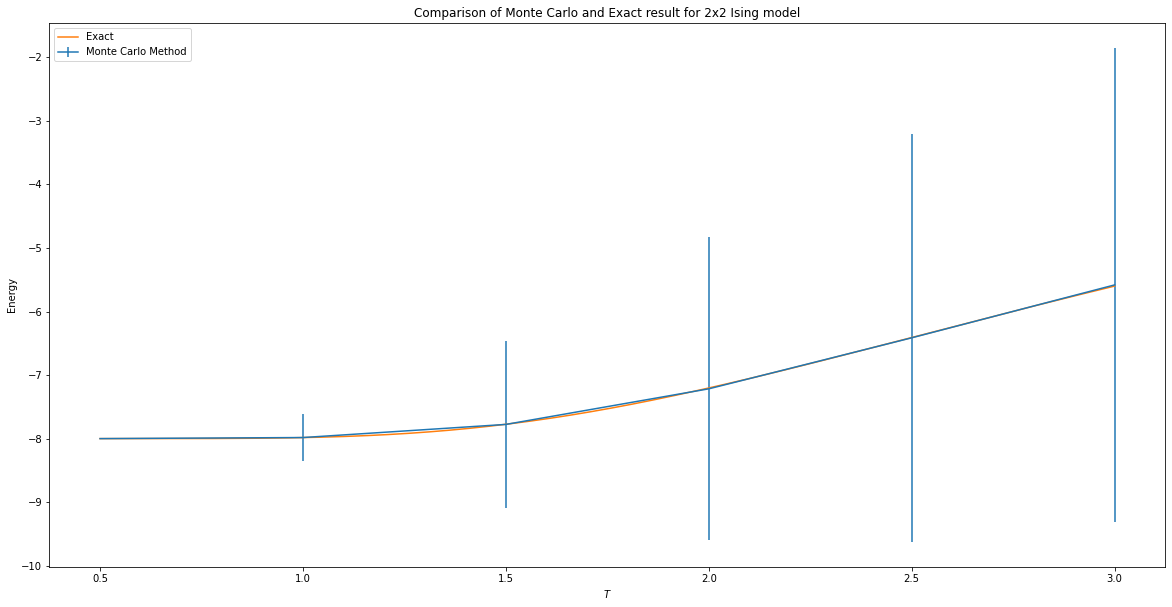

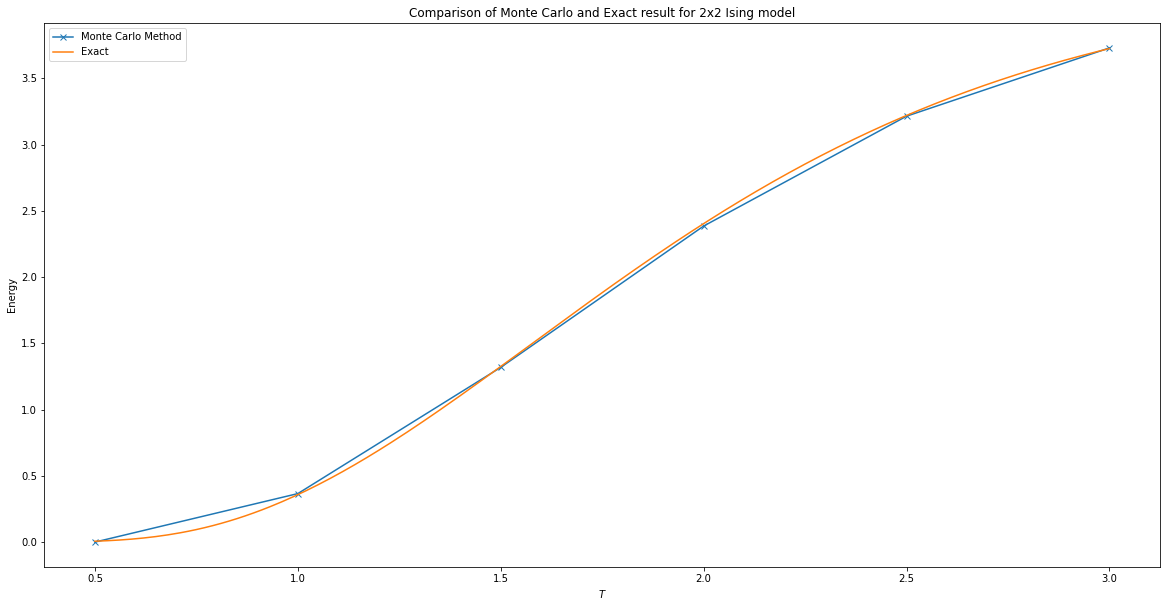

In [6]:
plt.errorbar(temps, E_mc, Estd_mc, label = 'Monte Carlo Method')
t_range = np.arange(0.5, 3.01, 0.01)
plt.plot(t_range, E_exact(t_range), label = 'Exact')
plt.legend(loc = 'upper left')
plt.ylabel("Energy")
plt.xlabel("$T$")
plt.title('Comparison of Monte Carlo and Exact result for 2x2 Ising model')
plt.savefig('2x2E.jpg', dpi = 600, bbox_inches = 'tight')
plt.show()
plt.plot(temps, Estd_mc, label = 'Monte Carlo Method', marker = 'x')
t_range = np.arange(0.5, 3.01, 0.01)
plt.plot(t_range, E_std_exact(t_range), label = 'Exact')
plt.legend(loc = 'upper left')
plt.ylabel("Energy")
plt.xlabel("$T$")
plt.title('Comparison of Monte Carlo and Exact result for 2x2 Ising model')
plt.show()

# $8\times8$ model

## Using Checkerboard

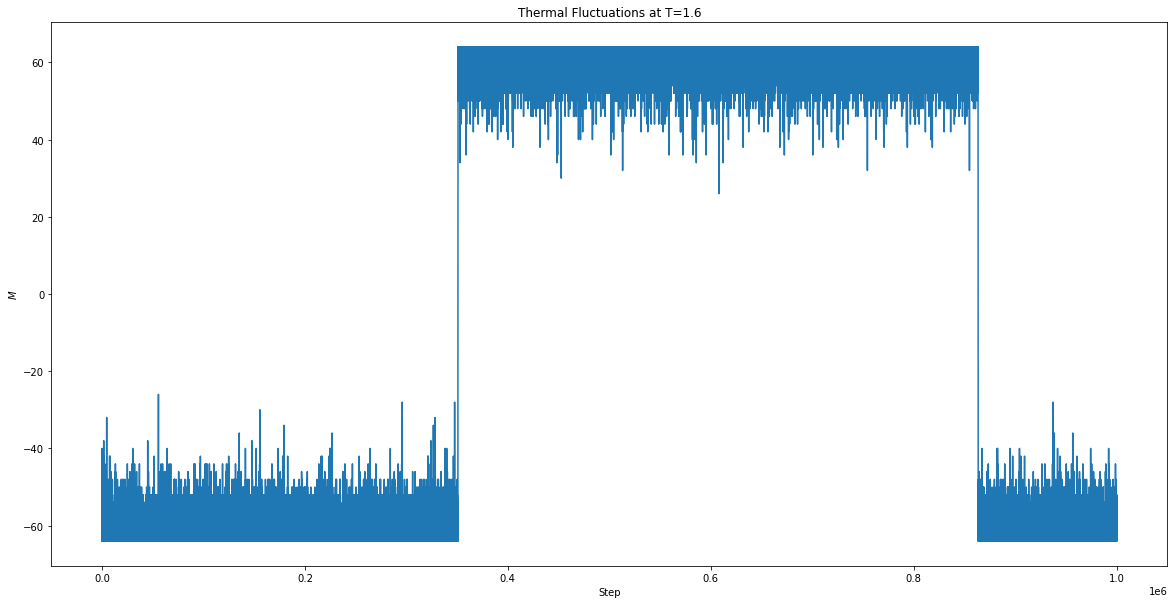

In [7]:
E_mc = []
Estd_mc = []

M_mc = []
Mstd_mc = []

abs_M_mc = []
abs_Mstd_mc = []

sq_M_mc = []
sq_Mstd_mc = []

temps = np.arange(1.5,3.1,0.1)
for temp in temps:
    E, M, _ = ising_mc_fast(L=8, T=temp,n_equib=50000, n_sim=500000)
    if temp==1.6:
        plt.plot(M)
        plt.xlabel('Step')
        plt.ylabel('$M$')
        plt.title(f'Thermal Fluctuations at T={temp}')
        plt.show()
    E_mc.append(np.mean(E))
    Estd_mc.append(np.std(E))
    # mean absolute value
    abs_M_mc.append(np.mean(np.abs(M))) # <|M|>
    abs_Mstd_mc.append(np.std(np.abs(M))) # error in <|M|>
    # absolute value of mean
    M_mc.append(np.mean(M)) # |<M>|
    Mstd_mc.append(np.std(M)) # error in |<M>|
    # Mean square value
    sq_M_mc.append(np.mean(np.square(M))) # |<M>|
    sq_Mstd_mc.append(np.std(np.square(M))) # error in |<M>|

E_mc = np.array(E_mc)
Estd_mc = np.array(Estd_mc)

M_mc = np.array(M_mc)
Mstd_mc = np.array(Mstd_mc)

abs_M_mc = np.array(abs_M_mc)
abs_Mstd_mc = np.array(abs_Mstd_mc)

sq_M_mc = np.array(sq_M_mc)
sq_Mstd_mc = np.array(sq_Mstd_mc)

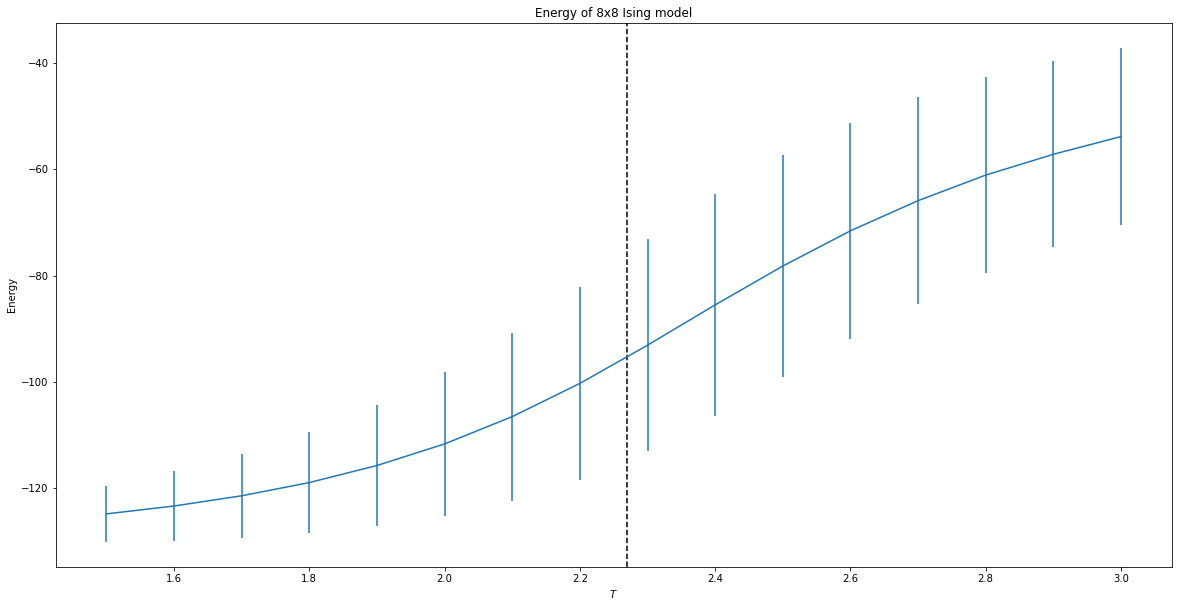

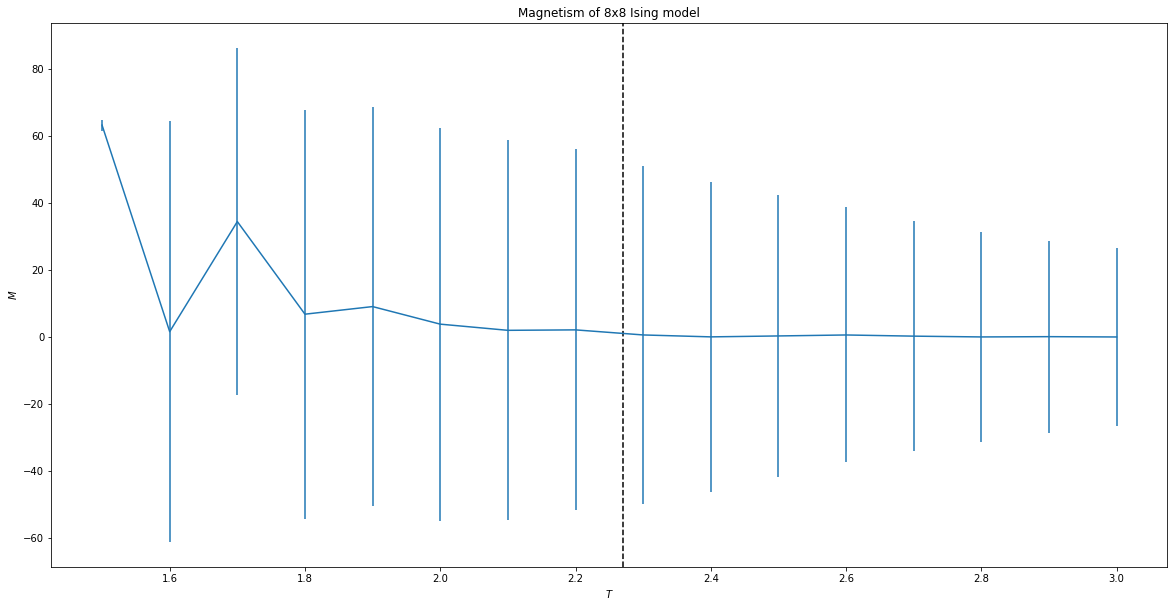

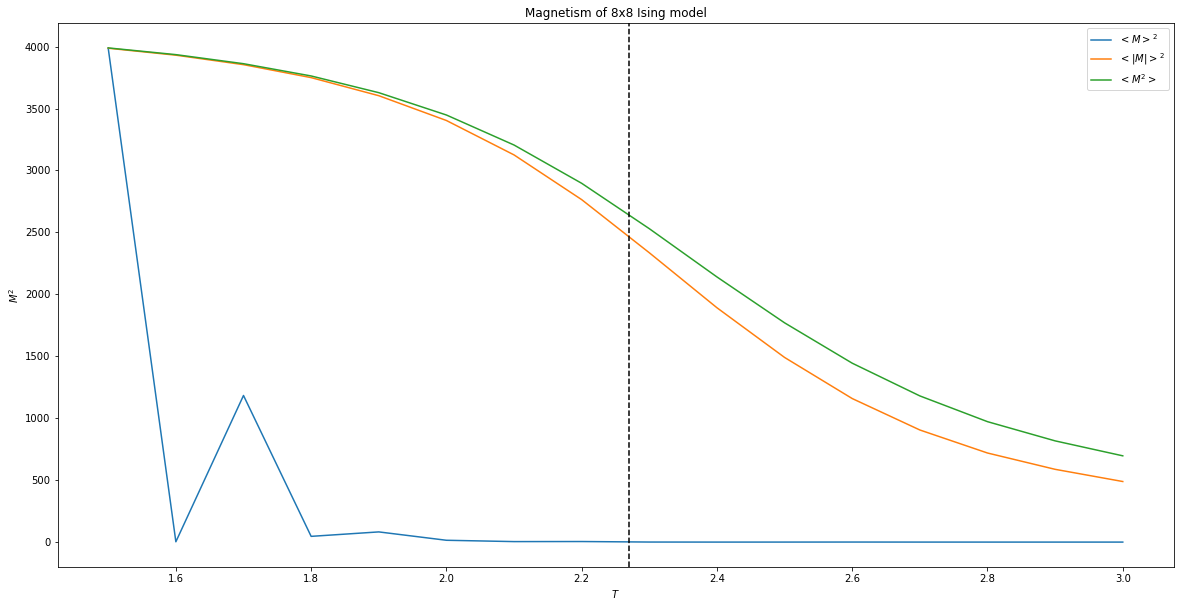

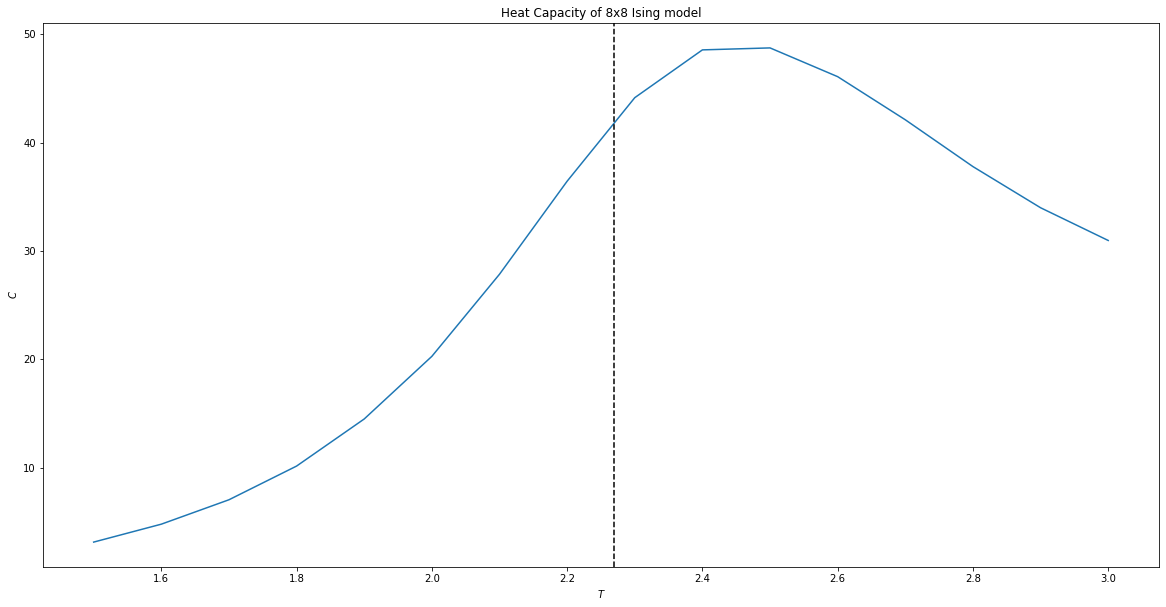

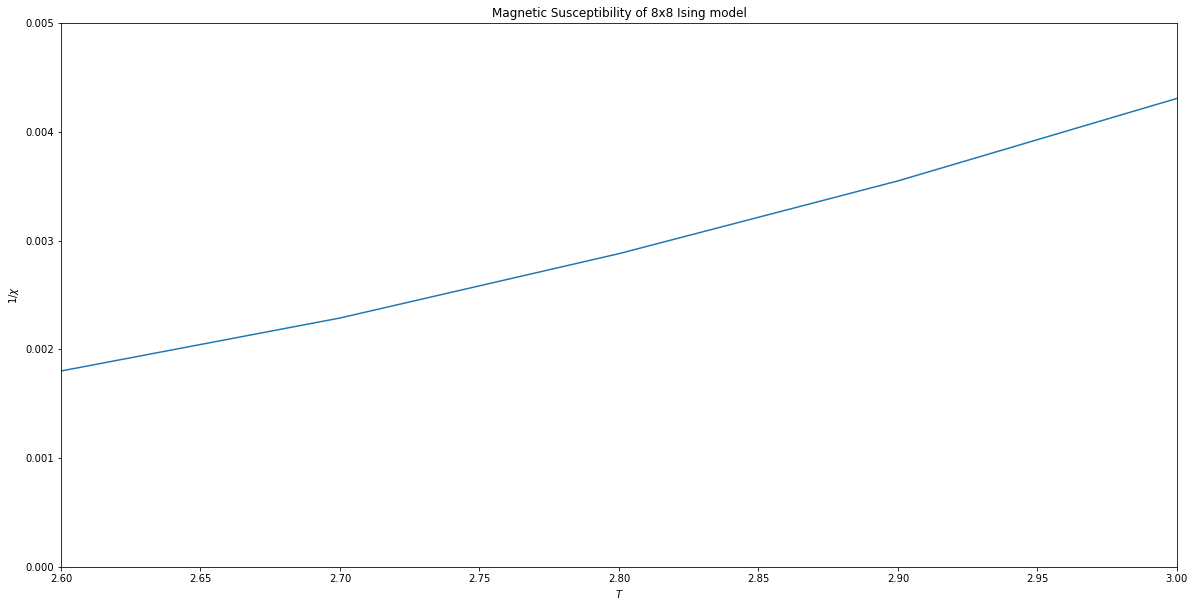

In [8]:
# energy against temperature
plt.errorbar(temps, E_mc, Estd_mc, label = 'Monte Carlo Method')
plt.ylabel("Energy")
plt.xlabel("$T$")
plt.title('Energy of 8x8 Ising model')
plt.axvline(2.27, linestyle = '--', c='black')
plt.savefig('8x8E.jpg', dpi = 600)
plt.show()
# absolute value of mean against temperature
plt.errorbar(temps, np.abs(M_mc), Mstd_mc, label = 'Monte Carlo Method')
plt.ylabel("$M$")
plt.xlabel("$T$")
plt.title('Magnetism of 8x8 Ising model')
plt.axvline(2.27, linestyle = '--', c='black')
plt.savefig('8x8M.jpg', dpi = 600)
plt.show()
# all
plt.plot(temps, np.square(M_mc), label = '$<M>^2$')#Mstd_mc,
plt.plot(temps, np.square(abs_M_mc), label = '$<|M|>^2$')#abs_Mstd_mc,
plt.plot(temps, sq_M_mc, label = '$<M^2>$')#abs_Mstd_mc,
plt.ylabel("$M^2$")
plt.xlabel("$T$")
plt.legend(loc = 'upper right')
plt.title('Magnetism of 8x8 Ising model')
plt.axvline(2.27, linestyle = '--', c='black')
plt.savefig('8x8M2.jpg', dpi = 600)
plt.show()
# Heat Capacity
plt.plot(temps, (Estd_mc/temp)**2, label = 'Monte Carlo Method')
plt.ylabel("$C$")
plt.xlabel("$T$")
plt.title('Heat Capacity of 8x8 Ising model')
plt.axvline(2.27, linestyle = '--', c='black')
plt.savefig('8x8C.jpg', dpi = 600)
plt.show()
plt.plot(temps, temps/((Mstd_mc)**2), label = 'Monte Carlo Method')
plt.ylabel("$1/\chi$")
plt.xlabel("$T$")
plt.xlim(2.6,3.0)
plt.ylim(0,0.005)
plt.title('Magnetic Susceptibility of 8x8 Ising model')
plt.axvline(2.27, linestyle = '--', c='black')
plt.savefig('8x8X.jpg', dpi = 600)
plt.show()

In [9]:
E_mc = []
Estd_mc = []
M_mc = []
Mstd_mc = []
mags = np.arange(0,3.1,0.1)
for mag in mags:
    E, M, _ = ising_mc_fast(L=8, T=3, B=mag, n_sim=500000)
    E_mc.append(np.mean(E))
    Estd_mc.append(np.std(E))
    M_mc.append(np.mean(np.abs(M)))
    Mstd_mc.append(np.std(np.abs(M)))
print(M_mc)

[22.097052, 26.982466, 35.407664, 41.927008, 46.273884, 49.28927, 51.512264, 53.208606, 54.558518, 55.658266, 56.574078, 57.345338, 58.00335, 58.579046, 59.08075, 59.51933, 59.91147, 60.260358, 60.569662, 60.84953, 61.101386, 61.328706, 61.536972, 61.725448, 61.899256, 62.057372, 62.201472, 62.334788, 62.455596, 62.567564, 62.67014]


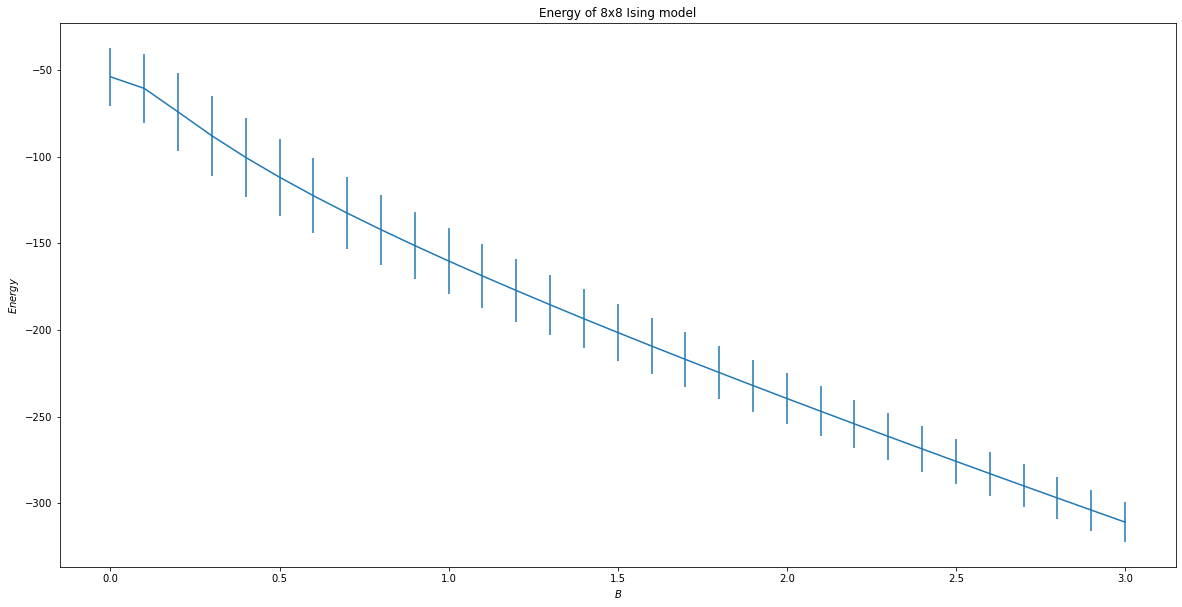

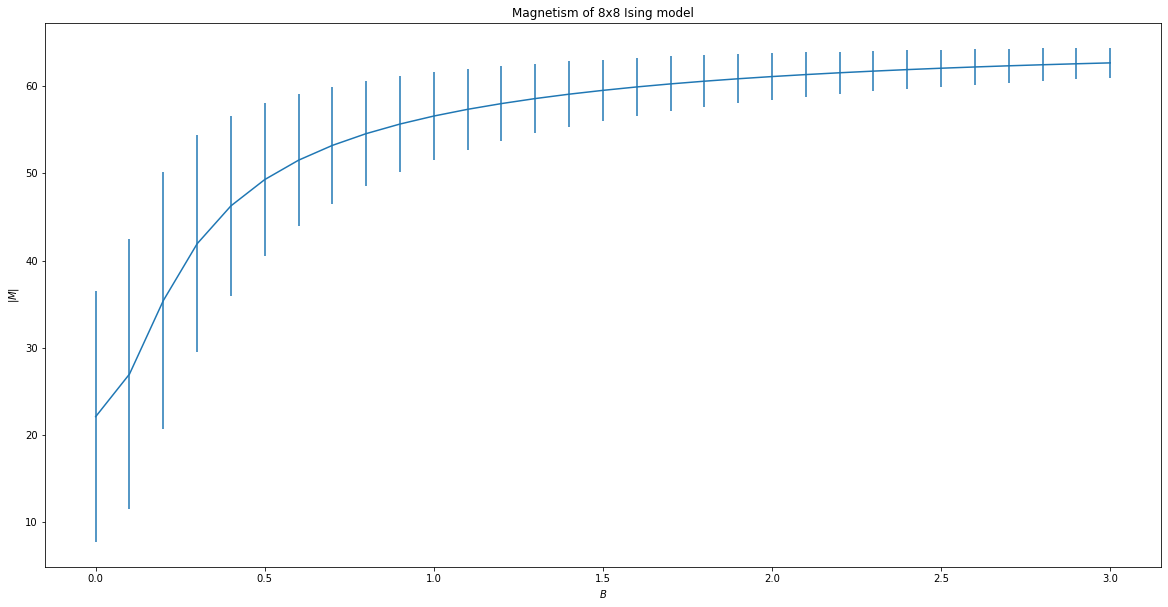

In [10]:
E_mc = np.array(E_mc)
Estd_mc = np.array(Estd_mc)
M_mc = np.array(M_mc)
Mstd_mc = np.array(Mstd_mc)
plt.errorbar(mags, E_mc, Estd_mc, label = 'Monte Carlo Method')
plt.ylabel("$Energy$")
plt.xlabel("$B$")
plt.title('Energy of 8x8 Ising model')
plt.savefig('8x8BE.jpg', dpi = 600)
plt.show()
plt.errorbar(mags, np.abs(M_mc), Mstd_mc, label = 'Monte Carlo Method')
plt.ylabel("$|M|$")
plt.xlabel("$B$")
plt.title('Magnetism of 8x8 Ising model')
plt.savefig('8x8BM.jpg', dpi = 600)
plt.show()

# $128 \times 128$ model
This takes around two and a half hours

1.50


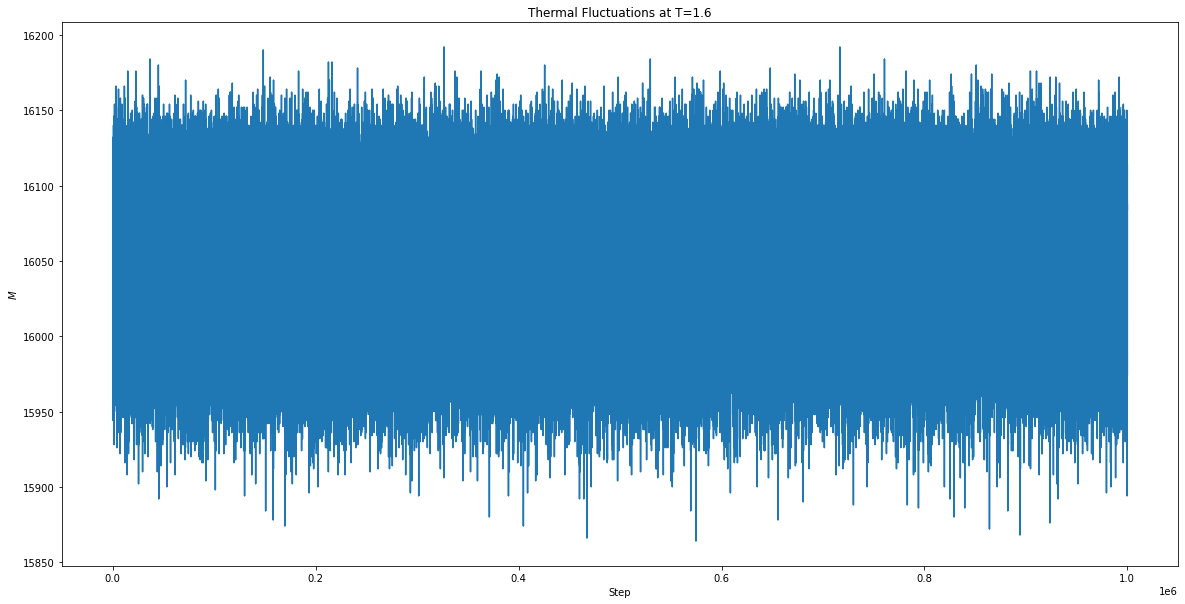

1.60
1.70
1.80
1.90
2.00
2.10
2.20
2.30
2.40
2.50
2.60
2.70
2.80
2.90
3.00


In [34]:
L = 128
E_mc = []
Estd_mc = []

M_mc = []
Mstd_mc = []

abs_M_mc = []
abs_Mstd_mc = []

sq_M_mc = []
sq_Mstd_mc = []

temps = np.arange(1.5,3.1,0.1)
for temp in temps:
    E, M, _ = ising_mc_fast(L=L, T=temp,n_equib=50000, n_sim=500000)
    if temp==1.6:
        plt.plot(M)
        plt.xlabel('Step')
        plt.ylabel('$M$')
        plt.title(f'Thermal Fluctuations at T={temp}')
        plt.show()
    E_mc.append(np.mean(E))
    Estd_mc.append(np.std(E))
    # mean absolute value
    abs_M_mc.append(np.mean(np.abs(M))) # <|M|>
    abs_Mstd_mc.append(np.std(np.abs(M))) # error in <|M|>
    # absolute value of mean
    M_mc.append(np.mean(M)) # |<M>|
    Mstd_mc.append(np.std(M)) # error in |<M>|
    # Mean square value
    sq_M_mc.append(np.mean(np.square(M))) # |<M>|
    sq_Mstd_mc.append(np.std(np.square(M))) # error in |<M>|
    print(f'{temp:0.2f}')
E_mc = np.array(E_mc)
Estd_mc = np.array(Estd_mc)

M_mc = np.array(M_mc)
Mstd_mc = np.array(Mstd_mc)

abs_M_mc = np.array(abs_M_mc)
abs_Mstd_mc = np.array(abs_Mstd_mc)

sq_M_mc = np.array(sq_M_mc)
sq_Mstd_mc = np.array(sq_Mstd_mc)

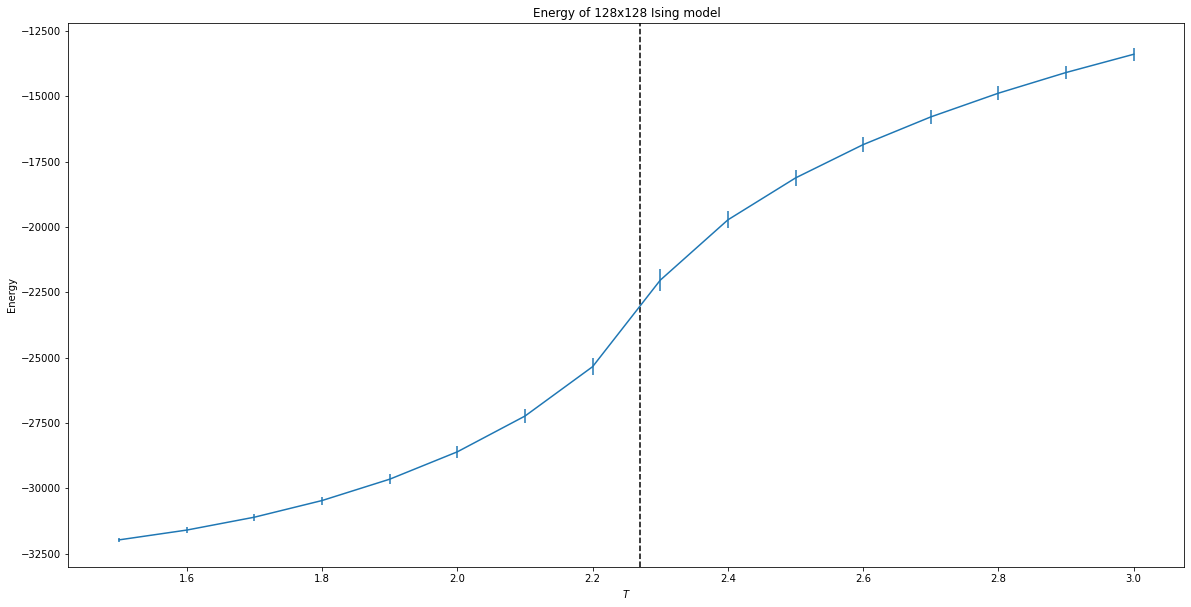

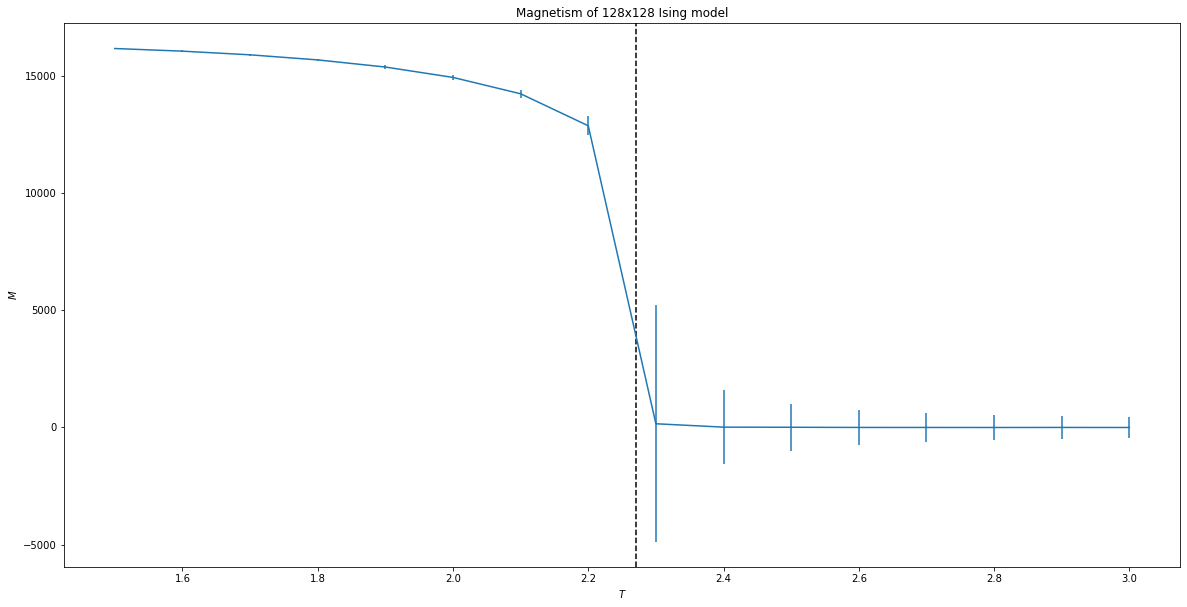

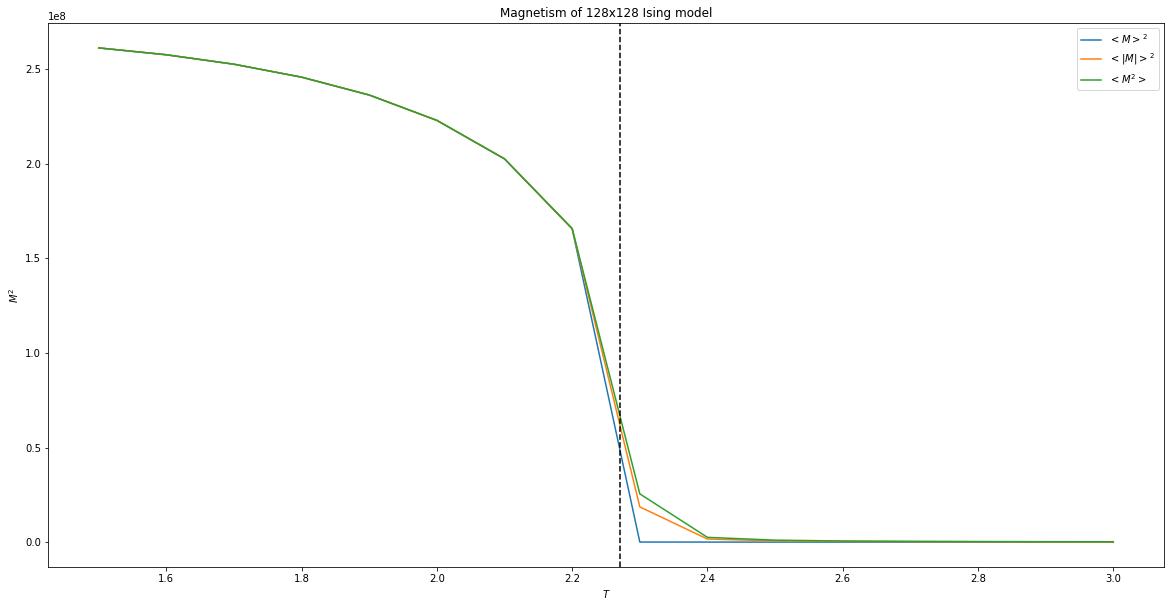

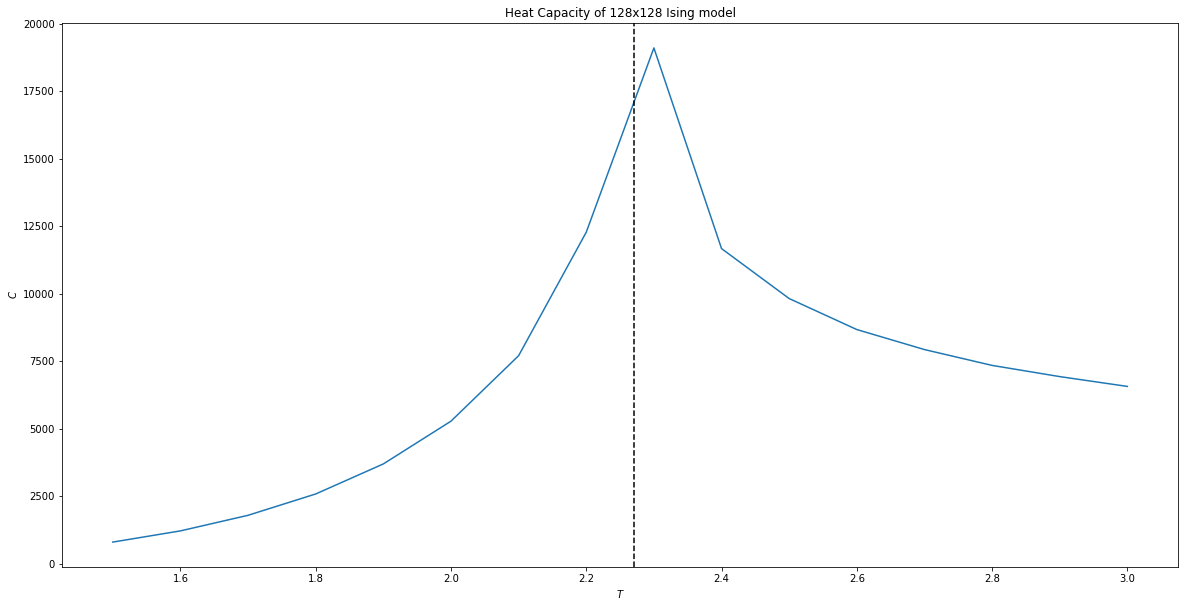

In [35]:
# energy against temperature
plt.errorbar(temps, E_mc, Estd_mc, label = 'Monte Carlo Method')
plt.ylabel("Energy")
plt.xlabel("$T$")
plt.title(f'Energy of {L}x{L} Ising model')
plt.axvline(2.27, linestyle = '--', c='black')
plt.show()
# absolute value of mean against temperature
plt.errorbar(temps, np.abs(M_mc), Mstd_mc, label = 'Monte Carlo Method')
plt.ylabel("$M$")
plt.xlabel("$T$")
plt.title(f'Magnetism of {L}x{L} Ising model')
plt.axvline(2.27, linestyle = '--', c='black')
plt.show()
# all
plt.plot(temps, np.square(M_mc), label = '$<M>^2$')#Mstd_mc,
plt.plot(temps, np.square(abs_M_mc), label = '$<|M|>^2$')#abs_Mstd_mc,
plt.plot(temps, sq_M_mc, label = '$<M^2>$')#abs_Mstd_mc,
plt.ylabel("$M^2$")
plt.xlabel("$T$")
plt.legend(loc = 'upper right')
plt.title(f'Magnetism of {L}x{L} Ising model')
plt.axvline(2.27, linestyle = '--', c='black')
plt.show()
# Heat Capacity
plt.plot(temps, (Estd_mc/temp)**2, label = 'Monte Carlo Method')
plt.ylabel("$C$")
plt.xlabel("$T$")
plt.title(f'Heat Capacity of {L}x{L} Ising model')
plt.axvline(2.27, linestyle = '--', c='black')
plt.show()